# MoBioFP - Fingertip Quality Analysis

In [1]:
import cv2
import imutils
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

/var/folders/1q/yrwnwqk10ts3wq83tjw7by7m0000gn/T/ipykernel_5566/2242261856.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def plot_histograms(df: pd.DataFrame, suptitle: str = None):
    _, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)

    if suptitle:
        plt.suptitle(suptitle, fontsize=16)

    # Plot histogram with KDE for Sharpness
    sns.histplot(data=df, x="Sharpness", bins=20, kde=True, color="blue", ax=axes[0])
    axes[0].set_xlabel("Sharpness")
    axes[0].set_ylabel("Density")
    # axes[0].set_title('Histogram with KDE of Sharpness')

    # Plot histogram with KDE for Contrast
    sns.histplot(data=df, x="Contrast", bins=20, kde=True, color="red", ax=axes[1])
    axes[1].set_xlabel("Contrast")
    axes[1].set_ylabel("Density")
    # axes[1].set_title('Histogram with KDE of Contrast')

    # Boxplot for Binary Mask Coverage
    sns.boxplot(data=df, x="Binary Mask Coverage", ax=axes[2], color="green")
    axes[2].set_xlabel("Binary Mask Coverage")
    axes[2].set_ylabel("Density")
    # axes[2].set_title('Histogram with KDE of Binary Mask Coverage')

    plt.show()


def plot_invalid_masks(loss_df: pd.DataFrame, fingertip_path: str, limit: int = 10):
    loss_df = loss_df.head(limit)

    images = []
    images_titles = []
    for _, row in loss_df.iterrows():
        image_file = Path(row["Image name"])
        mask_path = Path(fingertip_path) / "masks" / image_file.with_suffix(".png").name

        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        mask = imutils.resize(mask, width=128)
        images.append(mask)
        images_titles.append(mask_path.stem)

    # Determine the number of rows and columns for the subplot grid
    num_images = len(images)
    num_cols = 5  # Number of columns for the grid
    num_rows = math.ceil(num_images / num_cols)

    # Create a subplot grid
    fig, axes = plt.subplots(
        num_rows, num_cols, figsize=(15, 3 * num_rows), constrained_layout=True
    )
    axes = axes.ravel()  # Flatten the axes array

    # Plot the images
    for idx, (image, title) in enumerate(zip(images, images_titles)):
        axes[idx].imshow(image, cmap="gray")
        axes[idx].set_title(title, fontsize=10)
        axes[idx].axis("off")

    # Hide the remaining subplots
    for idx in range(num_images, num_cols * num_rows):
        axes[idx].axis("off")

    plt.show()


def data_loss(original_df: pd.DataFrame, filtered_df: pd.DataFrame) -> pd.DataFrame:
    original_count = len(original_df)
    filtered_count = len(filtered_df)
    data_loss = original_count - filtered_count
    percentage_loss = (data_loss / original_count) * 100

    print(f"Original dataset size: {original_count} images")
    print(f"Filtered dataset size: {filtered_count} images")
    print(f"Data loss: {data_loss} images ({percentage_loss:.2f}% loss)")

    # Extract indices of data loss images
    data_loss_indices = original_df[~original_df.index.isin(filtered_df.index)]

    # Return DataFrame containing only data loss images
    data_loss_df = original_df.loc[data_loss_indices.index]

    return data_loss_df

## Detection Fingertip Dataset

In [3]:
DETECTION_GALLERY_PATH = "../data/processed/detection/gallery"

df_det = pd.read_csv(DETECTION_GALLERY_PATH + "/quality_scores.csv")

### Show the first 5 rows of the dataset

In [4]:
df_det.head()

,Image name,Sharpness,Contrast,Binary Mask Coverage
0,18_i_1_w_4.jpg,30.104359,175,78.288809
1,35_i_2_w_3.jpg,98.729238,141,76.973513
2,43_i_1_w_1.jpg,57.211027,83,74.655248
3,29_i_2_w_2.jpg,110.428321,122,73.878740
4,17_i_2_w_5.jpg,30.246203,182,82.556010


### Summary Statistics

In [5]:
df_det.describe()

,Sharpness,Contrast,Binary Mask Coverage
count,992.000000,992.000000,992.000000
mean,75.444739,117.263105,74.048989
std,36.170342,41.015519,9.510343
min,20.107067,49.000000,0.180403
25%,48.337962,79.000000,74.348980
50%,69.449802,108.000000,76.039500
75%,96.768539,155.000000,77.517966
max,345.446456,203.000000,82.556010


### Initial Distribution Analysis

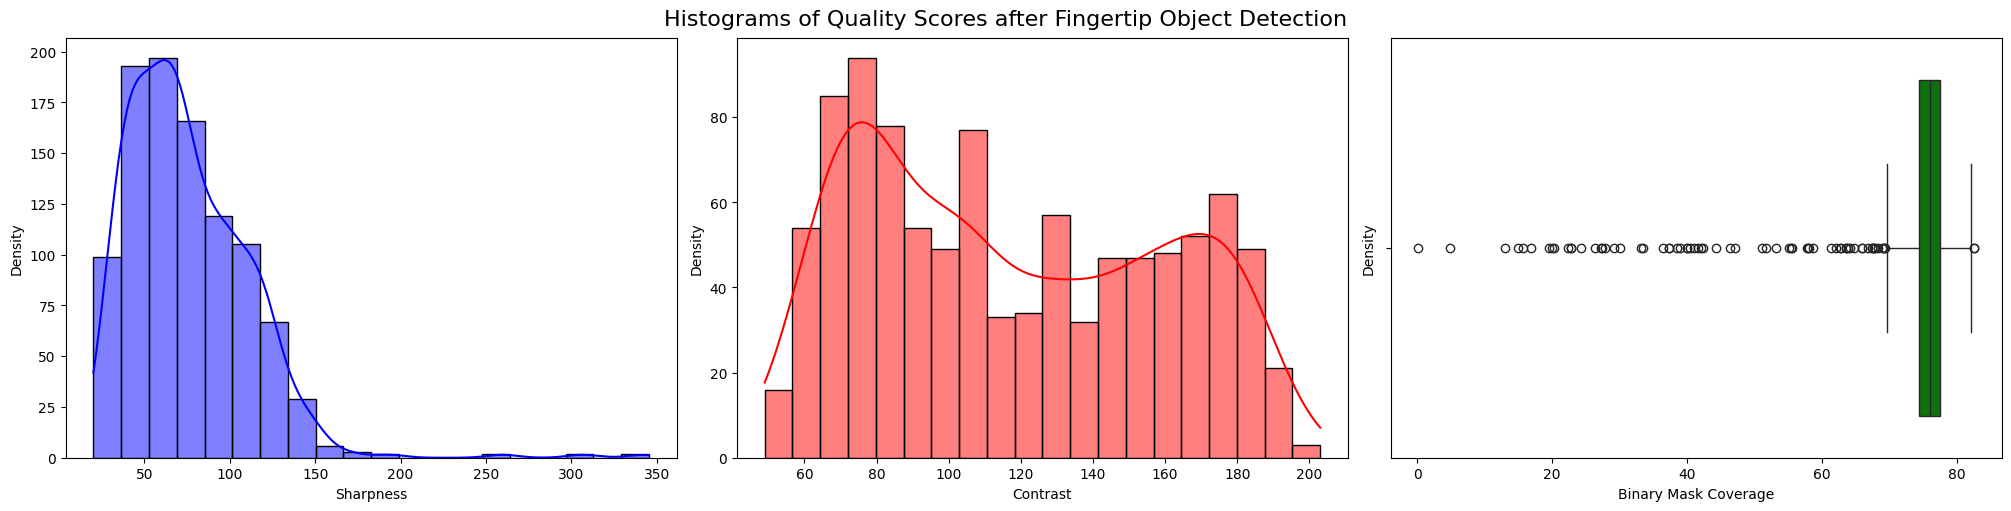

In [6]:
plot_histograms(df_det, "Histograms of Quality Scores after Fingertip Object Detection")

### Binary Mask Coverage Treshold Distribution Analysis and Data Loss

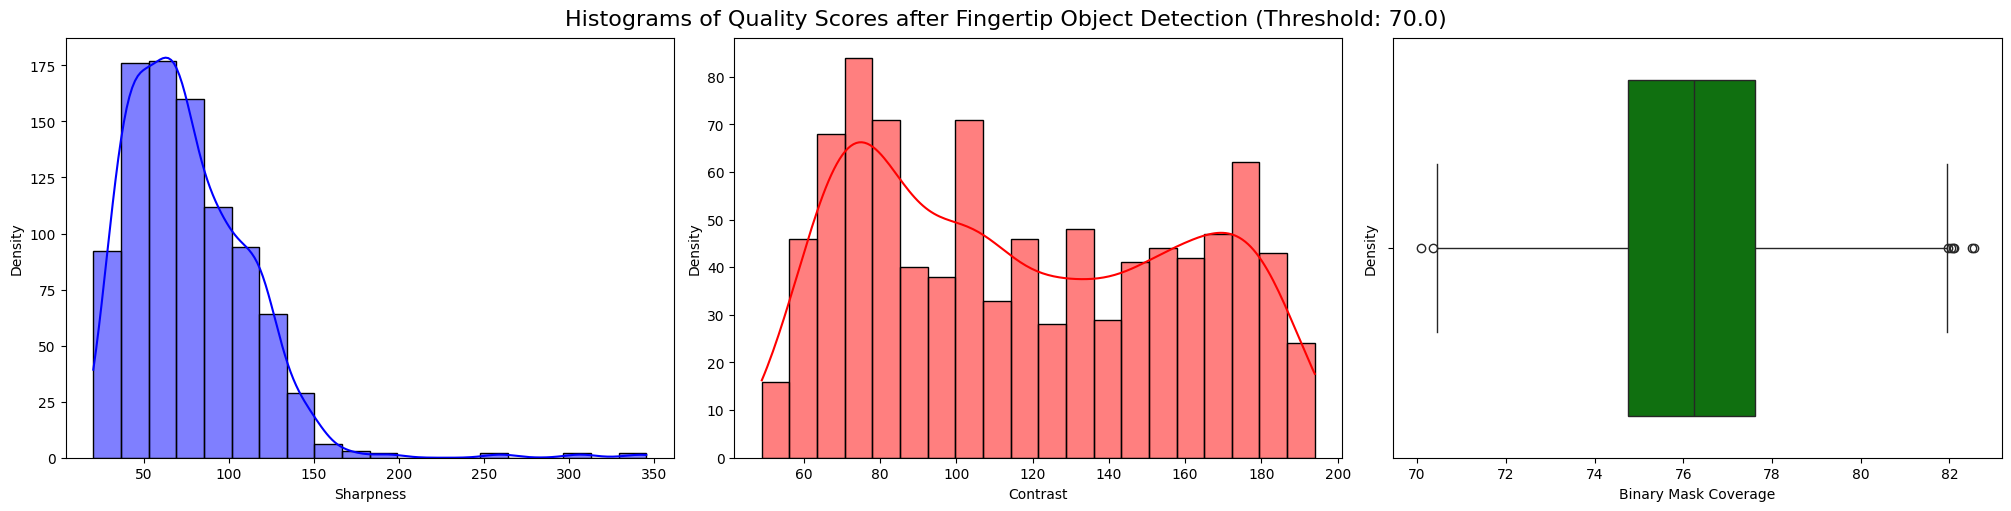

Original dataset size: 992 images
Filtered dataset size: 921 images
Data loss: 71 images (7.16% loss)


In [7]:
# Define the threshold for binary mask coverage
threshold = 70.0

# Filter the DataFrame based on the threshold
filtered_df = df_det[(df_det["Binary Mask Coverage"] >= threshold)]

plot_histograms(
    filtered_df,
    f"Histograms of Quality Scores after Fingertip Object Detection (Threshold: {threshold})",
)
loss_df = data_loss(df_det, filtered_df)

### Show Invalid Images

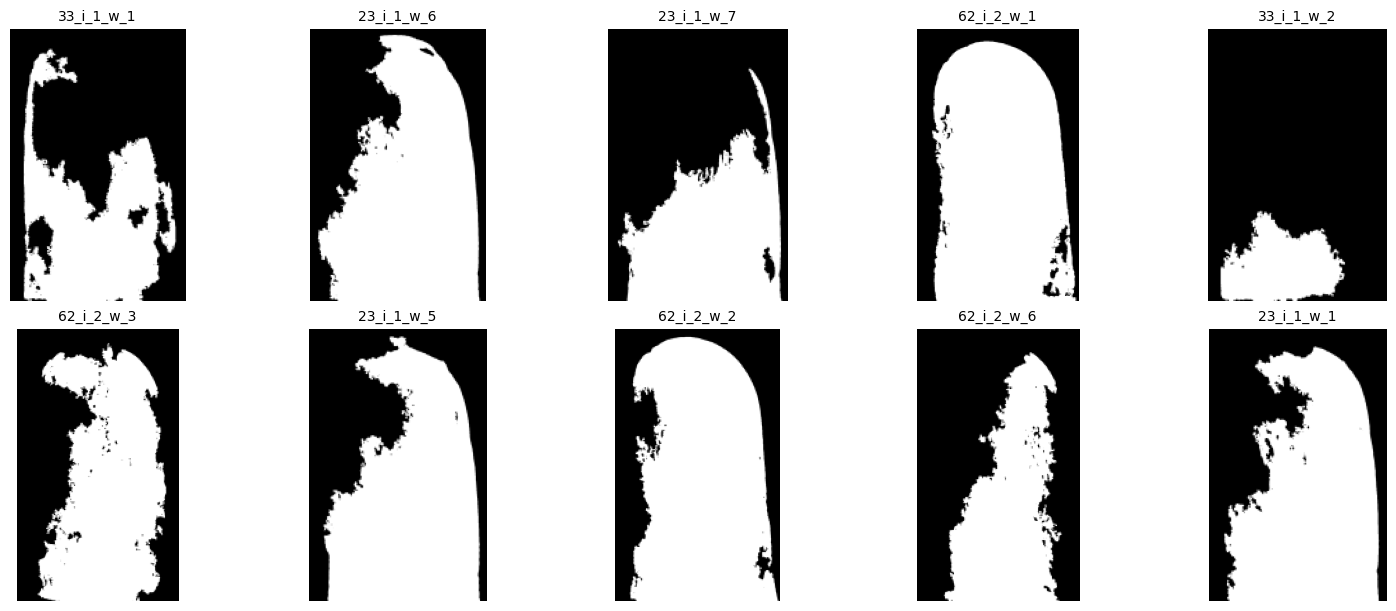

In [8]:
plot_invalid_masks(loss_df, DETECTION_GALLERY_PATH)

## Segmentation Fingertip Dataset

In [9]:
SEGMENTATION_GALLERY_PATH = "../data/processed/segmentation/gallery"

df_seg = pd.read_csv(SEGMENTATION_GALLERY_PATH + "/quality_scores.csv")

### Show the first 5 rows of the dataset

In [10]:
df_seg.head()

,Image name,Sharpness,Contrast,Binary Mask Coverage
0,18_i_1_w_4.jpg,33.221326,180,70.170911
1,35_i_2_w_3.jpg,140.931436,151,74.129004
2,43_i_1_w_1.jpg,122.365238,119,71.993472
3,29_i_2_w_2.jpg,169.351407,153,71.169712
4,17_i_2_w_5.jpg,37.001282,198,73.054399


### Summary Statistics

In [11]:
df_seg.describe()

,Sharpness,Contrast,Binary Mask Coverage
count,992.000000,992.000000,992.000000
mean,122.036279,137.573589,70.932005
std,57.266265,37.922123,2.519798
min,29.247767,58.000000,59.037820
25%,76.062309,105.000000,69.528633
50%,114.323632,139.000000,71.116247
75%,159.629254,171.000000,72.693171
max,368.099452,205.000000,77.019665


### Initial Distribution Analysis

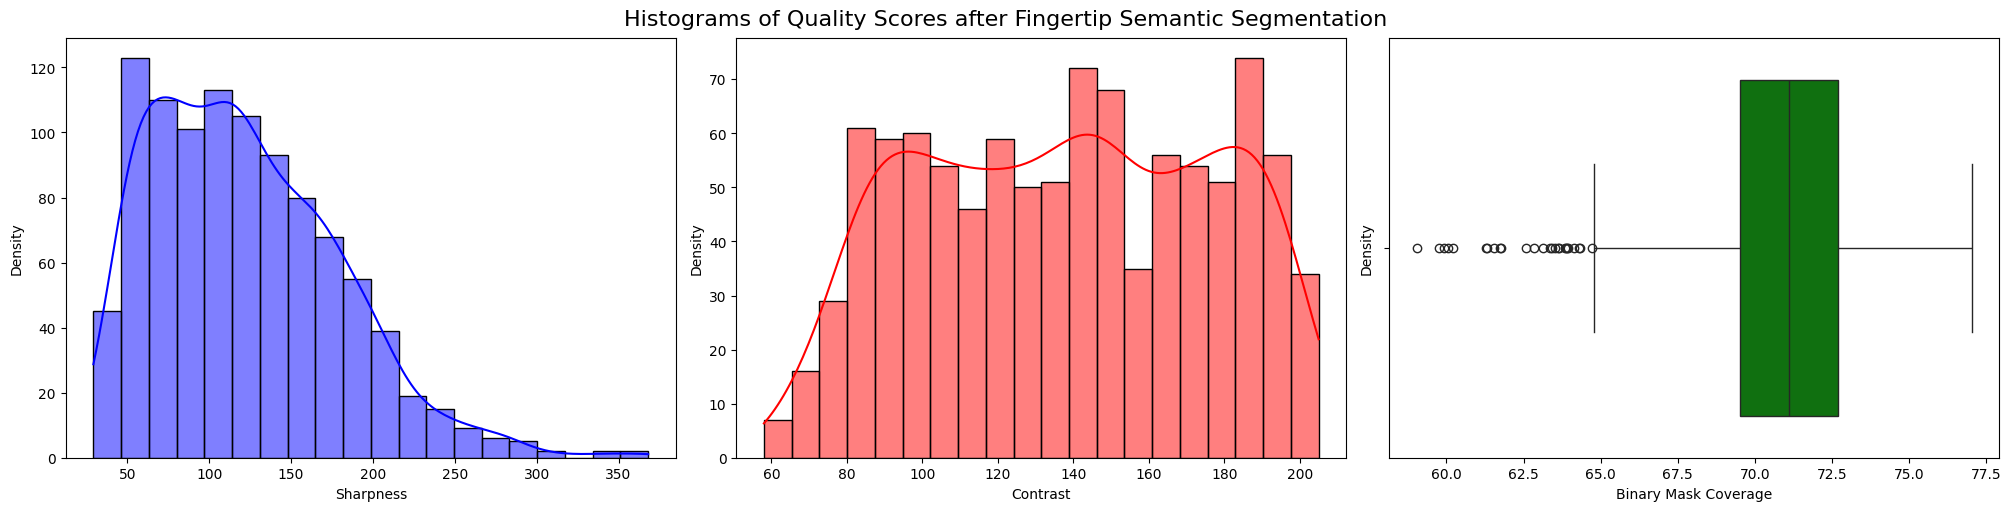

In [12]:
plot_histograms(
    df_seg, f"Histograms of Quality Scores after Fingertip Semantic Segmentation"
)

### Binary Mask Coverage Treshold Distribution Analysis and Data Loss

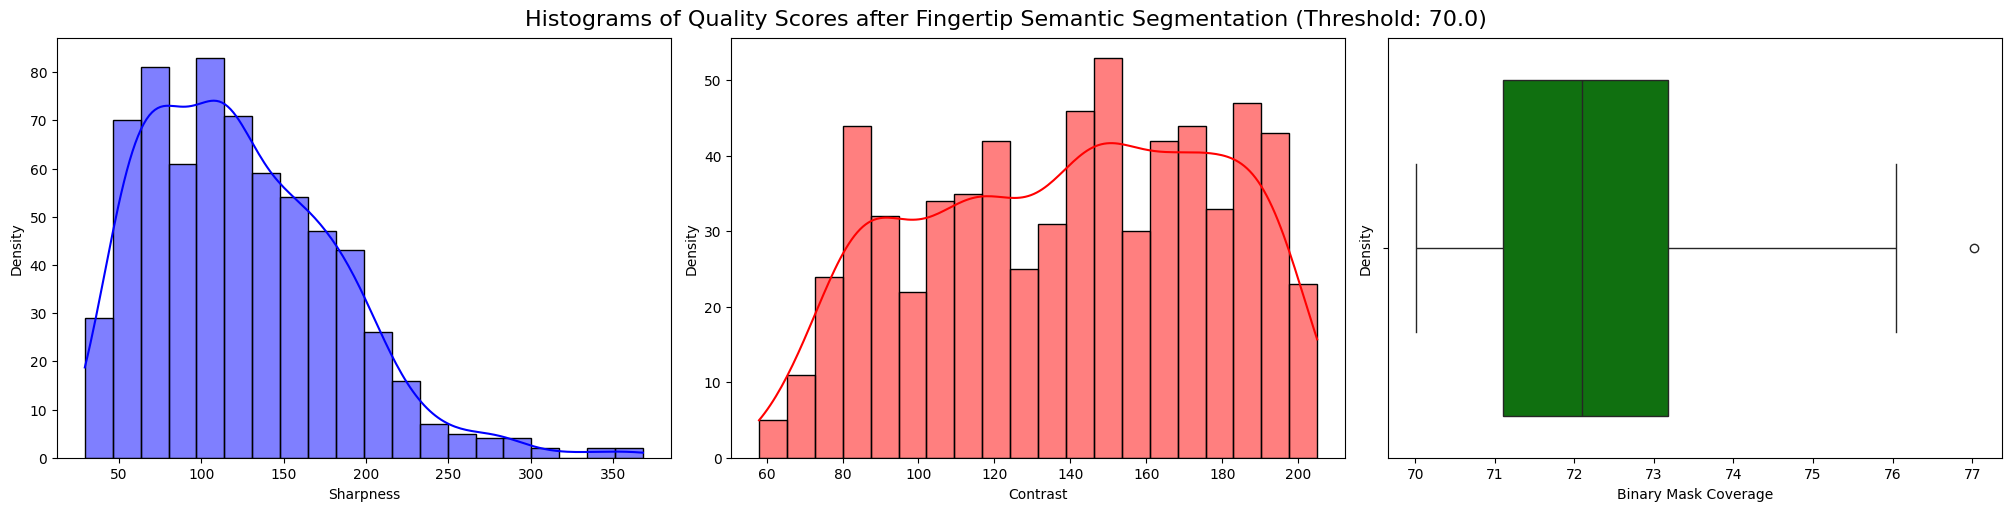

Original dataset size: 992 images
Filtered dataset size: 666 images
Data loss: 326 images (32.86% loss)


In [13]:
# Define the threshold for binary mask coverage
threshold = 70.0

# Filter the DataFrame based on the threshold
filtered_df = df_seg[df_seg["Binary Mask Coverage"] >= threshold]

plot_histograms(
    filtered_df,
    f"Histograms of Quality Scores after Fingertip Semantic Segmentation (Threshold: {threshold})",
)
loss_df = data_loss(df_seg, filtered_df)

### Show invalid masks

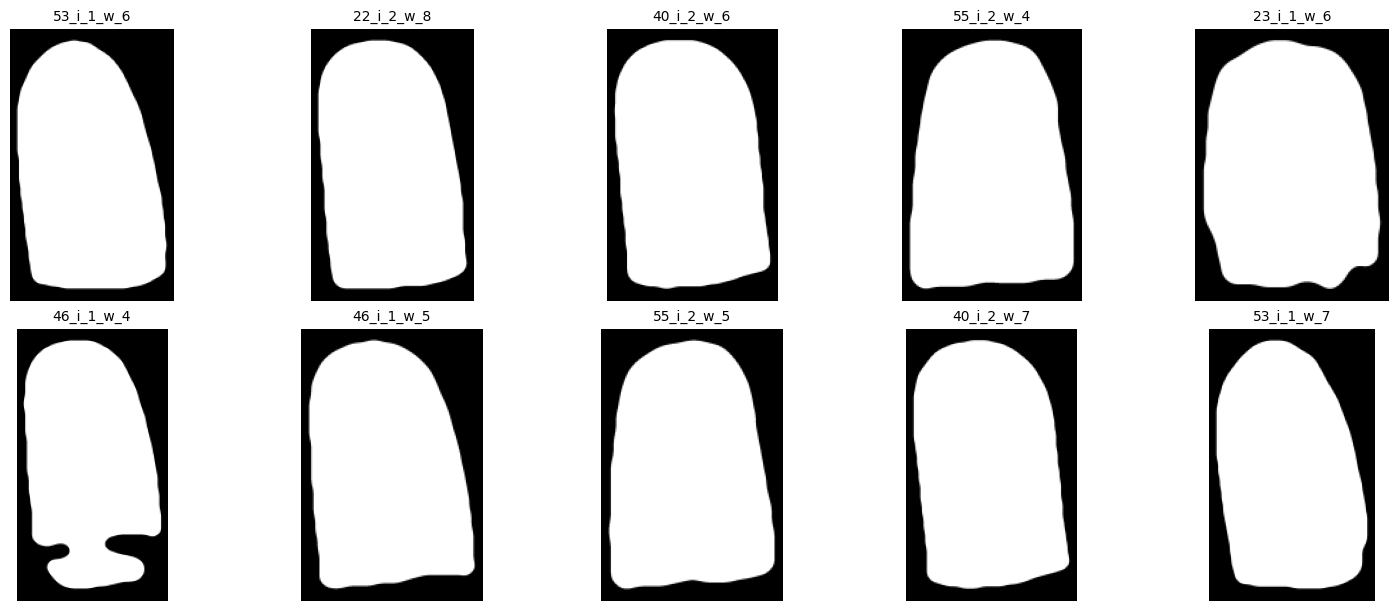

In [14]:
plot_invalid_masks(loss_df, SEGMENTATION_GALLERY_PATH)